# 📊 Amazon Forecast Dataset
> Andika Rahman Teja

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

# 🔎 EDA

In [2]:
df = pd.read_csv('Test Macine Learning Enginer Inosoft_AMZN.csv') 
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [3]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6516.000000,6516.000000,6516.000000,6516.000000,6516.000000,6.516000e+03
mean,31.611626,31.991995,31.193432,31.599740,31.599740,1.425338e+08
std,48.095343,48.659651,47.464476,48.060258,48.060258,1.401619e+08
min,0.070313,0.072396,0.065625,0.069792,0.069792,9.744000e+06
25%,1.998875,2.028500,1.964750,2.001250,2.001250,6.888182e+07
50%,6.456750,6.535500,6.353250,6.444250,6.444250,1.059050e+08
75%,38.451375,38.688000,38.203001,38.464625,38.464625,1.607700e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.086584e+09


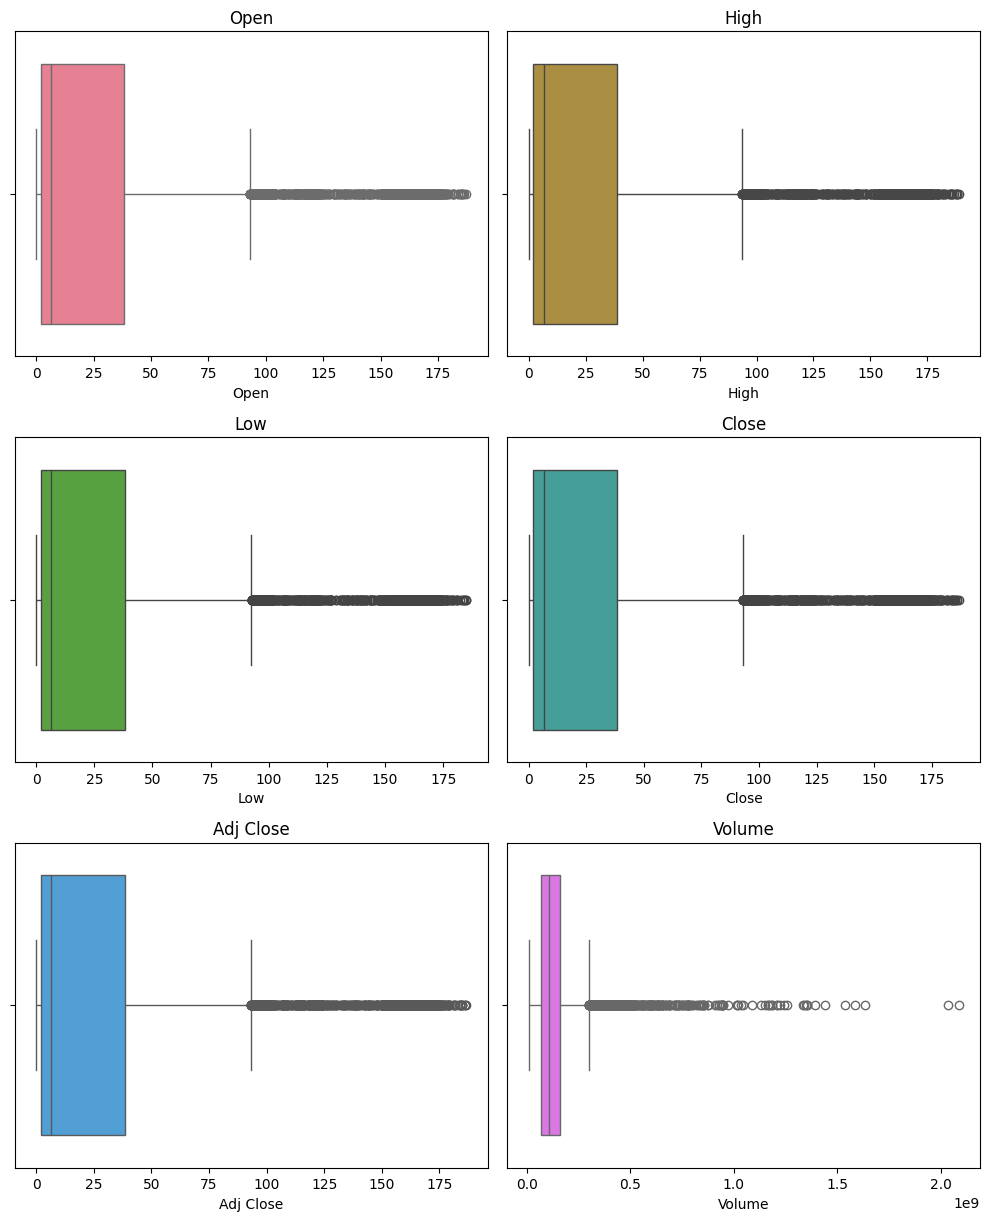

In [7]:
plt.figure(figsize=(10, 20))
palette = sns.color_palette("husl", len(df.columns) - 1)
color_idx = 0
for indeks, kolom in enumerate(df.columns):
    if kolom == 'Date':
        continue
    plt.subplot(5, 2, indeks)
    sns.boxplot(x=df[kolom], color=palette[color_idx])
    plt.title(kolom)
    color_idx += 1
plt.tight_layout()
plt.show()

In [8]:
# Cek urutan timeseries
df['Date'] = pd.to_datetime(df['Date'])

is_sorted = df['Date'].is_monotonic_increasing

if not is_sorted:
    print("Data tidak terurut berdasarkan tanggal. Mengurutkan data...")
    df = df.sort_values(by='Date').reset_index(drop=True)

print("Data sudah terurut berdasarkan tanggal.")

Data sudah terurut berdasarkan tanggal.


In [9]:
tanggal_awal = df['Date'].min()
tanggal_akhir = df['Date'].max()
rentang_tanggal = pd.date_range(start=tanggal_awal, end=tanggal_akhir, freq='D')

tanggal_hilang = rentang_tanggal.difference(df['Date'])
if len(tanggal_hilang) > 0:
    df_tanggal_hilang = pd.DataFrame({'Tanggal Hilang': tanggal_hilang})
    df_tanggal_hilang['Hari'] = df_tanggal_hilang['Tanggal Hilang'].dt.day_name()
    print("Tanggal yang hilang:")
    display(df_tanggal_hilang)
else:
    print("Tidak ada tanggal yang hilang dalam data.")

Tanggal yang hilang:


,Tanggal Hilang,Hari
0,1997-05-17,Saturday
1,1997-05-18,Sunday
2,1997-05-24,Saturday
3,1997-05-25,Sunday
4,1997-05-26,Monday
...,...,...
2936,2023-03-19,Sunday
2937,2023-03-25,Saturday
2938,2023-03-26,Sunday
2939,2023-04-01,Saturday


In [10]:
tanggal_hilang_weekday = [tanggal for tanggal in tanggal_hilang if tanggal.weekday() < 5]

if len(tanggal_hilang_weekday) > 0:
    df_missing_weekday = pd.DataFrame({'Tanggal Hilang Weekday': tanggal_hilang_weekday})
    print("Tanggal hilang (weekday saja):")
    display(df_missing_weekday)
else:
    print("Tidak ada tanggal weekday yang hilang dalam data.")

Tanggal hilang (weekday saja):


,Tanggal Hilang Weekday
0,1997-05-26
1,1997-07-04
2,1997-09-01
3,1997-11-27
4,1997-12-25
...,...
234,2022-11-24
235,2022-12-26
236,2023-01-02
237,2023-01-16


In [11]:
weekend_data = df[df['Date'].dt.weekday >= 5]

if not weekend_data.empty:
    print("Ada tanggal weekend di data!")
    display(weekend_data)
else:
    print("Tidak ada tanggal weekend di data.")

Tidak ada tanggal weekend di data.


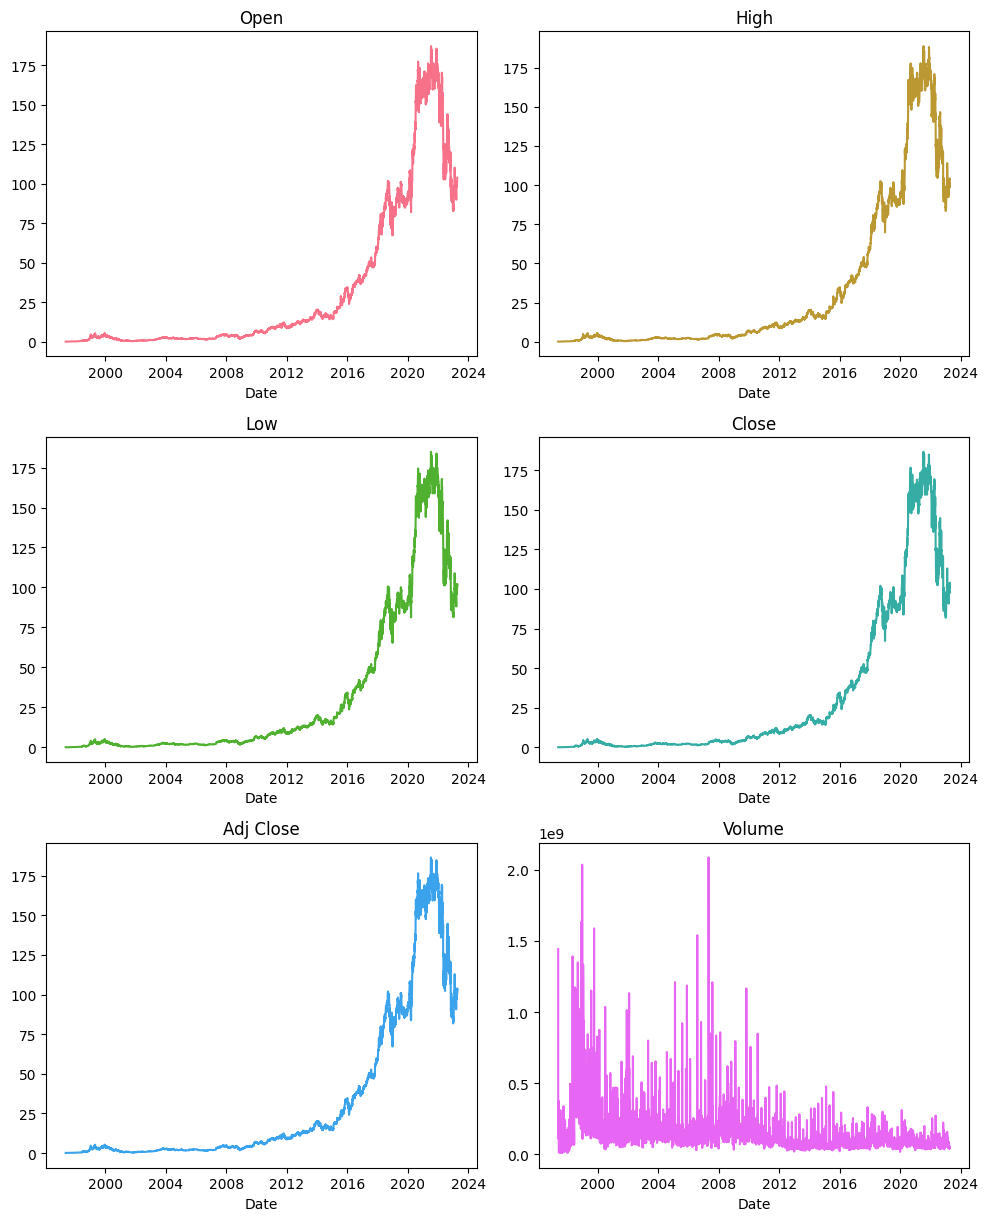

In [12]:
palette = sns.color_palette("husl", len(df.columns) - 1)
plt.figure(figsize=(10, 20))
color_idx = 0
for indeks, kolom in enumerate(df.columns):
    if kolom == 'Date':
        continue
    plt.subplot(5, 2, indeks)
    plt.plot(df['Date'], df[kolom], color=palette[color_idx])
    plt.title(kolom)
    plt.xlabel('Date')
    color_idx += 1
plt.tight_layout()
plt.show()

In [13]:
# Ambil data 3 tahun terakhir
df_last = df[df['Date'] >= (df['Date'].max() - pd.DateOffset(years=3))]
df_last = df_last.reset_index(drop=True)
print("Data 3 tahun terakhir:")
df_last

Data 3 tahun terakhir:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-06,96.800003,99.926003,96.500999,99.879501,99.879501,115464000
1,2020-04-07,100.855499,101.786003,99.880997,100.580002,100.580002,102280000
2,2020-04-08,101.050003,102.199997,100.557503,102.150002,102.150002,79546000
3,2020-04-09,102.214996,102.650002,100.883003,102.138000,102.138000,92930000
4,2020-04-13,102.000000,109.000000,101.900002,108.443497,108.443497,134334000
...,...,...,...,...,...,...,...
751,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
752,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
753,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
754,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


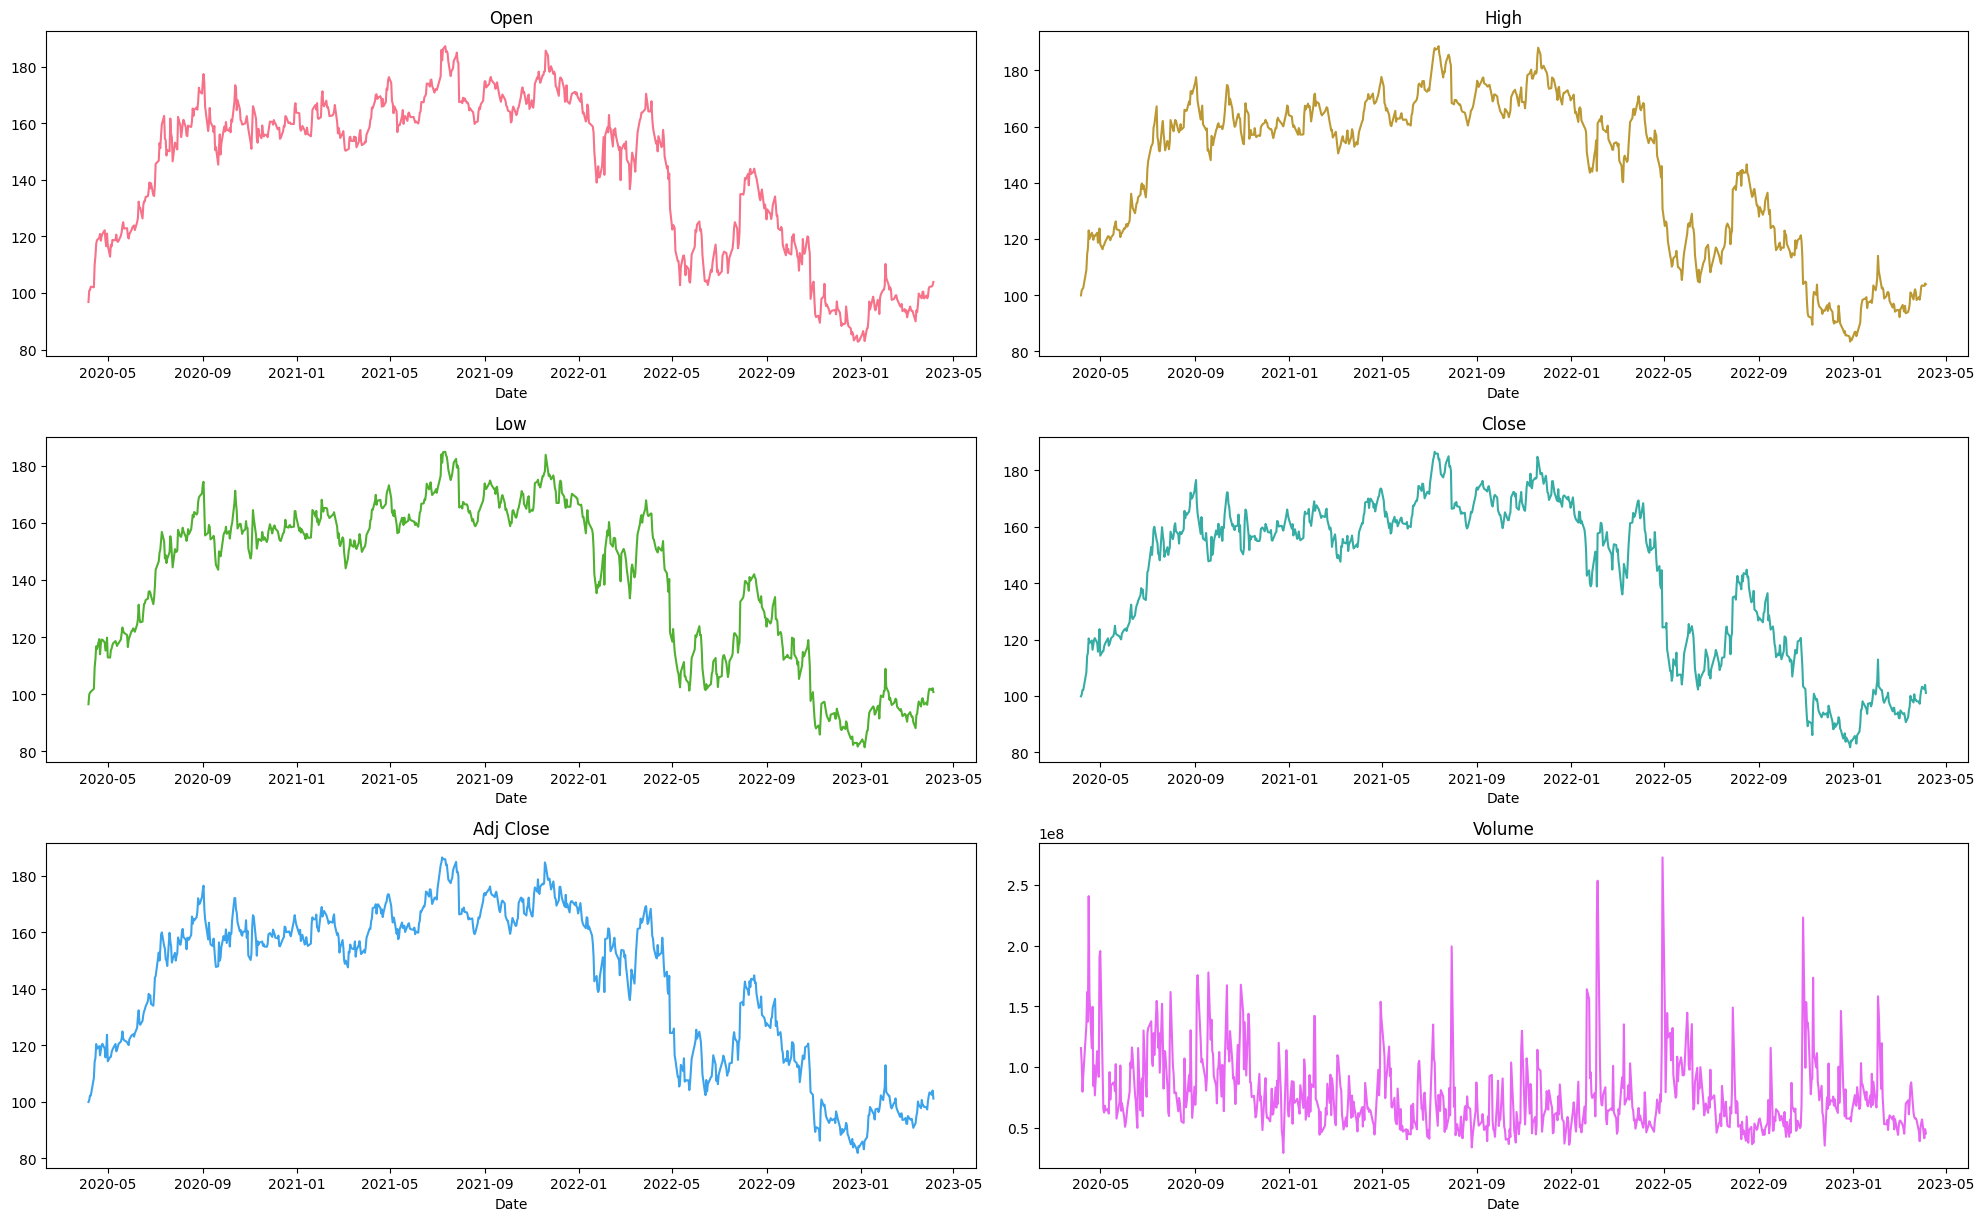

In [14]:
palette = sns.color_palette("husl", len(df_last.columns) - 1)
plt.figure(figsize=(20, 20))
color_idx = 0
for indeks, kolom in enumerate(df_last.columns):
    if kolom == 'Date':
        continue
    plt.subplot(5, 2, indeks)
    plt.plot(df_last['Date'], df_last[kolom], color=palette[color_idx])
    plt.title(kolom)
    plt.xlabel('Date')
    color_idx += 1
plt.tight_layout()
plt.show()

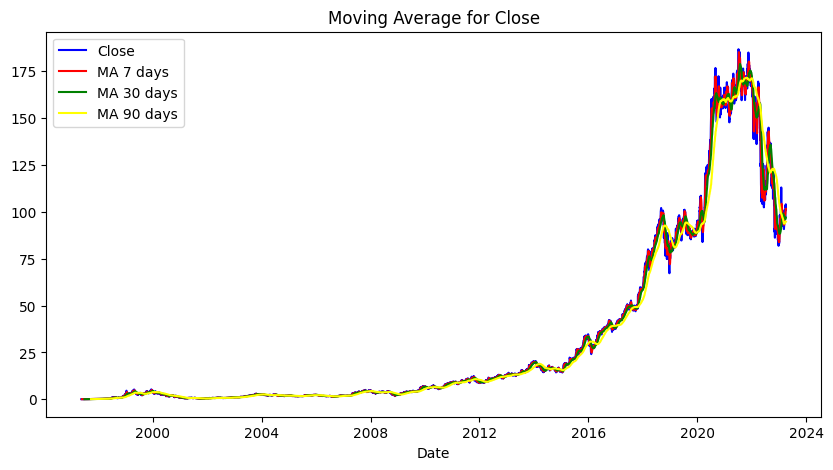

In [15]:
# Moving Average
window_day = [7, 30, 90]
for window in window_day:
    df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
    
# Plot Moving Average
colors = ['blue', 'red', 'green', 'yellow']
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Close', color=colors[0])
for idx, window in enumerate(window_day):
    plt.plot(df['Date'], df[f'MA_{window}'], label=f'MA {window} days', color=colors[idx + 1])
plt.title('Moving Average for Close')
plt.xlabel('Date')
plt.legend()
plt.show()

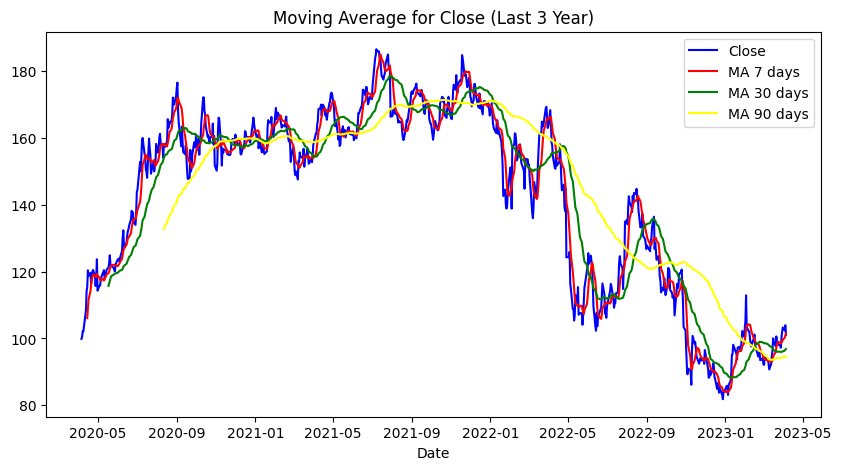

In [16]:
# Moving Average untuk data 3 tahun terakhir
for window in window_day:
    df_last[f'MA_{window}'] = df_last['Close'].rolling(window=window).mean()
    
# Plot Moving Average untuk data 3 tahun terakhir
plt.figure(figsize=(10, 5))
plt.plot(df_last['Date'], df_last['Close'], label='Close', color=colors[0])
for idx, window in enumerate(window_day):
    plt.plot(df_last['Date'], df_last[f'MA_{window}'], label=f'MA {window} days', color=colors[idx + 1])
plt.title('Moving Average for Close (Last 3 Year)')
plt.xlabel('Date')
plt.legend()
plt.show()

# 💡 Insight Data

## Kondisi Data
Dataset ini **tidak memiliki missing value**. Selain itu, dataset ini juga **memiliki outlier** dikarenakan adanya trend penjualan yang meningkat pada tahun-tahun tertentu.

Data ini juga hanya **dicatat ketika hari kerja** (weekday) dan tidak ada data pada hari libur (weekend).

## Tren Penjualan
Data penjualan semula mengalami **stagnasi** hingga sekitar tahun 2010. Kemudian terus mengalami **peningkatan secara bertahap** hingga tahun 2018. Hal ini disebabkan karena akses internet yang semakin cepat, perangkat mobile yang berkembang, dan juga adanya sosial media sebagai salah satu upaya marketing perusahaan ritel (Algharabat & Rana, 2020; Bădîrcea et al., 2022). 

Pada tahun rentang waktu 2018-2019, sempat terjadi penurunan namun pada akhir tahun 2019 kembali mengalami peningkatan. Bahkan pada tahun 2020, penjualan mengalami **lonjakan yang signifikan**. Hal ini kemungkinan disebabkan oleh adanya **pandemi COVID-19** yang membuat banyak orang beralih ke belanja online (Alwan et al., 2023).

Pada tahun 2022, grafik penjualan **relatif mengalami penurunan**. Hal ini disebabkan oleh faktor seperti perubahan perilaku konsumen (mulai banyak kegiatan di luar rumah) hingga persaingan yang semakin ketat di industri e-commerce (Abirami et al., 2023).

# ⚙️ Preprocessing

> Sebagai catatan, pada test kali ini akan menggunakan metode AutoRegressive berdasarkan fitur `close` saja.

In [17]:
df_train = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
df_train = scaler.fit_transform(df_train)

In [18]:
time_step = 30
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

In [19]:
X, y = [], []
for i in range(time_step, len(df_train)):
    X.append(df_train[i-time_step:i, 0])
    y.append(df_train[i, 0])

X = np.array(X)  
y = np.array(y)

X = X.reshape((X.shape[0], X.shape[1], 1))  # (N_samples, time_step, 1)

In [20]:
test_size = 0.1
n_test = int(len(X) * test_size)
n_train_val = len(X) - n_test

X_train_val, X_test = X[:n_train_val], X[n_train_val:]
y_train_val, y_test = y[:n_train_val], y[n_train_val:]

In [21]:
print(f"X_train shape: {X_train_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (5838, 30, 1), X_test shape: (648, 30, 1)


In [22]:
print(f"y_train shape: {y_train_val.shape}, y_test shape: {y_test.shape}")

y_train shape: (5838,), y_test shape: (648,)


> Dengan pembagian data seperti ini, maka:
> - Data training dan validation akan dibagi pada 3 periode waktu, dengan tiap periode berisi 7 tahun. Hal ini dilakukan untuk memastikan model dapat memahami pattern data yang berbeda-beda pada tiap periode.
> - Data testing akan berisi data 2-3 tahun terakhir (2021-2023). Ini bagus karena dapat memprediksi tren penjualan pasca pandemi COVID-19.
> - Adapun rolling window yang digunakan adalah 30 hari (1 bulan)

In [23]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
trainval_dataset = TensorDataset(
    torch.tensor(X_train_val, dtype=torch.float32, device=device),
    torch.tensor(y_train_val, dtype=torch.float32, device=device)
)
trainval_loader = DataLoader(trainval_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32, device=device),
    torch.tensor(y_test, dtype=torch.float32, device=device)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ⚠️ Prepare for Train Model

In [25]:
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [26]:
def evaluate_predictions(predictions, targets):
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)
    return mse, rmse, r2

In [27]:
def train_per_fold(model_class, X_train, y_train, X_val, y_val, n_epochs=50, batch_size=32):
    model = model_class().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32, device=device),
        torch.tensor(y_train, dtype=torch.float32, device=device)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(
        torch.tensor(X_val, dtype=torch.float32, device=device),
        torch.tensor(y_val, dtype=torch.float32, device=device)
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), targets)
                total_val_loss += loss.item() * inputs.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            
    preds_val_scaled = []
    trues_val_scaled = []
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # outputs.view(-1) menghasilkan list prediksi (batch_size,)
            preds_val_scaled.extend(outputs.view(-1).cpu().numpy().tolist())
            trues_val_scaled.extend(targets.cpu().numpy().tolist())

    preds_val_scaled = np.array(preds_val_scaled)
    trues_val_scaled = np.array(trues_val_scaled)
    mse_scaled, rms_scaled, r2_scaled = evaluate_predictions(preds_val_scaled, trues_val_scaled)
    
    preds_val_original = scaler.inverse_transform(preds_val_scaled.reshape(-1, 1)).flatten()
    trues_val_original = scaler.inverse_transform(trues_val_scaled.reshape(-1, 1)).flatten()
    mse_original, rms_original, r2_original = evaluate_predictions(preds_val_original, trues_val_original)
    
    print(f"Scaled Predictions - MSE: {mse_scaled:.4f}, RMSE: {rms_scaled:.4f}, R²: {r2_scaled:.4f}")
    print(f"Original Predictions - MSE: {mse_original:.4f}, RMSE: {rms_original:.4f}, R²: {r2_original:.4f}")
    plot_losses(train_losses, val_losses)
    return model, preds_val_scaled, trues_val_scaled, preds_val_original, trues_val_original

In [28]:
def cross_validate_time_series(model_class, X_train_val, y_train_val, tscv, num_epochs):
    fold_metrics = []
    fold_models = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X_train_val)):
        print("\n" + "="*50)
        print(f"Fold {fold + 1}/{tscv.n_splits}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        model, preds_val_scaled, trues_val_scaled, preds_val_original, trues_val_original = train_per_fold(
            model_class, X_train, y_train, X_val, y_val, n_epochs=num_epochs
        )
        
        fold_metrics.append({
            'fold': fold + 1,
            'mse': mean_squared_error(trues_val_original, preds_val_original),
            'rmse': np.sqrt(mean_squared_error(trues_val_original, preds_val_original)),
            'r2_score': r2_score(trues_val_original, preds_val_original)
        })
        
        fold_models.append(model.state_dict())
    return fold_metrics, fold_models

# Model 1 => LSTM

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

lstm_model = LSTMModel().to(device)
summary(lstm_model, input_size=(32, time_step, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 1]                   --
├─LSTM: 1-1                              [32, 30, 64]              50,432
├─Linear: 1-2                            [32, 1]                   65
Total params: 50,497
Trainable params: 50,497
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 48.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 0.20
Estimated Total Size (MB): 0.70

In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
num_epochs = 50


Fold 1/3
Epoch 1/50, Train Loss: 0.0007, Val Loss: 0.0001
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0000
Scaled Predictions - MSE: 0.0000, RMSE: 0.0007, R²: 0.9751
Original Predictions - MSE: 0.0191, RMSE: 0.1382, R²: 0.9751


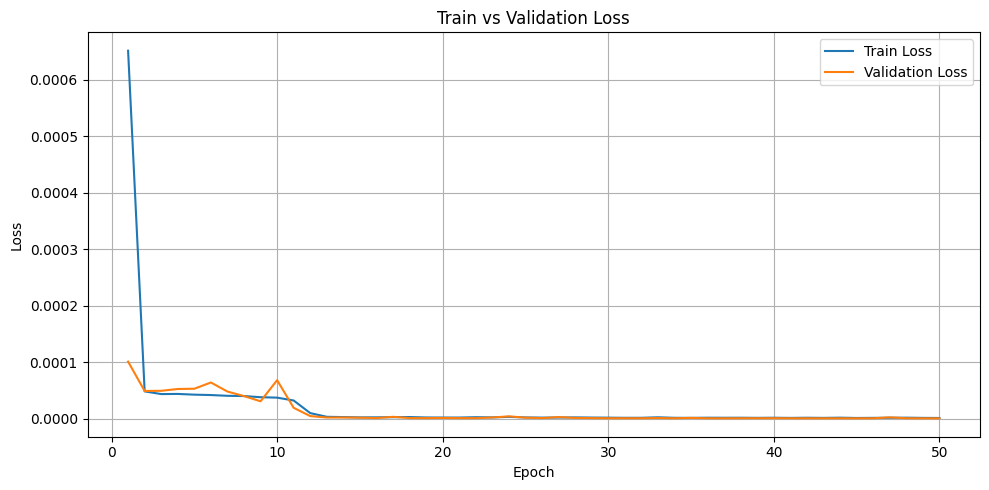


Fold 2/3
Epoch 1/50, Train Loss: 0.0012, Val Loss: 0.0026
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0025
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0000
Scaled Predictions - MSE: 0.0000, RMSE: 0.0019, R²: 0.9931
Original Predictions - MSE: 0.1306, RMSE: 0.3615, R²: 0.9931


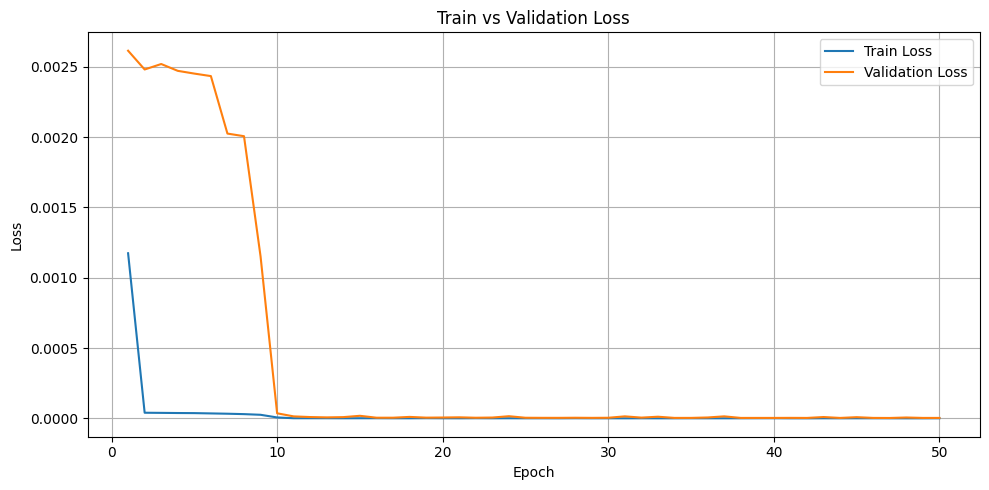


Fold 3/3
Epoch 1/50, Train Loss: 0.0003, Val Loss: 0.0011
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0022
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0021
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0008
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0004
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0003
Scaled Predictions - MSE: 0.0006, RMSE: 0.0244, R²: 0.9827
Original Predictions - MSE: 20.7200, RMSE: 4.5519, R²: 0.9827


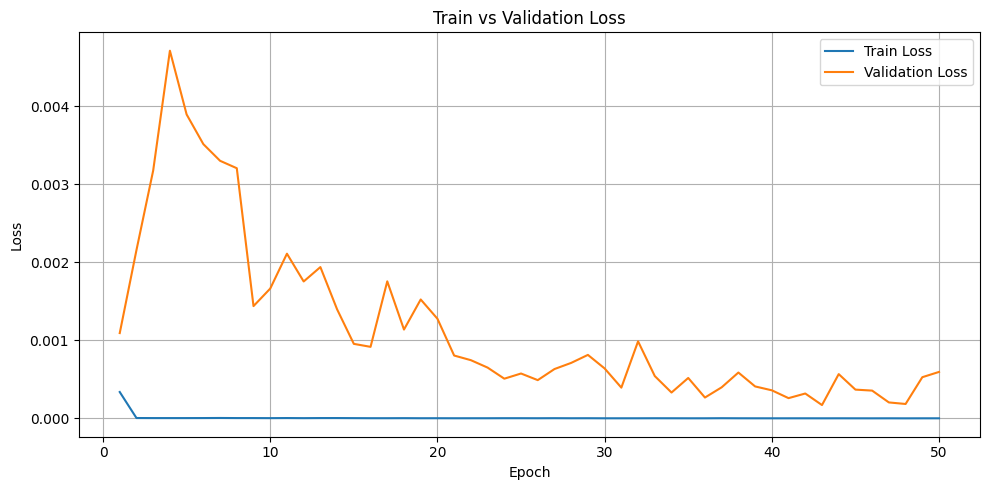

In [31]:
lstm_fold_metrics = []
lstm_fold_models = []

lstm_fold_metrics, lstm_fold_models = cross_validate_time_series(LSTMModel, 
                                                                 X_train_val, 
                                                                 y_train_val, 
                                                                 tscv, 
                                                                 num_epochs)

In [32]:
print(f"Rata-rata metrik per fold:")
lstm_fold_metrics_df = pd.DataFrame(lstm_fold_metrics)
lstm_fold_metrics_df = lstm_fold_metrics_df.drop(columns=['fold'])
lstm_fold_metrics_df.mean()

Rata-rata metrik per fold:


mse         6.956580
rmse        1.683857
r2_score    0.983668
dtype: float64

In [33]:
lstm_model = LSTMModel(input_size=1, hidden_size=64, num_layers=2).to(device)
optimizer_final = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

lstm_losses = []
for epoch in range(1, num_epochs + 1):
    lstm_model.train()
    epoch_loss = 0.0
    for inputs, targets in trainval_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer_final.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer_final.step()
        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(trainval_loader.dataset)
    lstm_losses.append(avg_loss)
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.6f}")

Epoch [1/50], Loss: 0.006056
Epoch [10/50], Loss: 0.000070
Epoch [20/50], Loss: 0.000051
Epoch [30/50], Loss: 0.000031
Epoch [40/50], Loss: 0.000032
Epoch [50/50], Loss: 0.000031


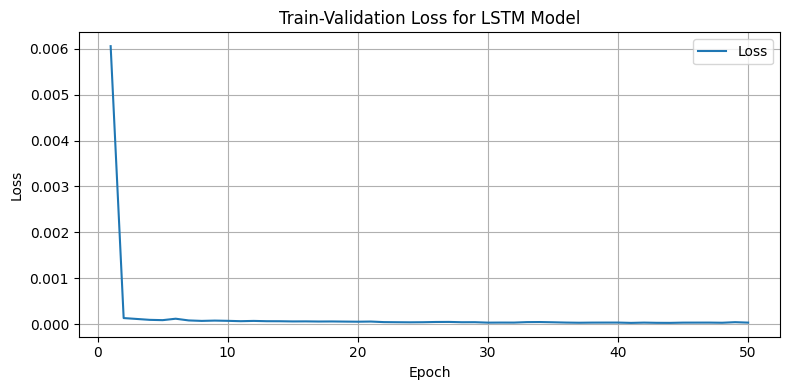

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), lstm_losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train‐Validation Loss for LSTM Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
lstm_model.eval()
preds_test_scaled = []
trues_test_scaled = []
model_metrics = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = lstm_model(inputs)
        preds_test_scaled.extend(outputs.view(-1).cpu().numpy().tolist())
        trues_test_scaled.extend(targets.cpu().numpy().tolist())

preds_test_scaled = np.array(preds_test_scaled)
trues_test_scaled = np.array(trues_test_scaled)

preds_test_orig = scaler.inverse_transform(preds_test_scaled.reshape(-1, 1)).flatten()
trues_test_orig = scaler.inverse_transform(trues_test_scaled.reshape(-1, 1)).flatten()

mse_test = mean_squared_error(trues_test_orig, preds_test_orig)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(trues_test_orig, preds_test_orig)

model_metrics.append({
    'model': 'LSTM',
    'mse': mse_test,
    'rmse': rmse_test,
    'r2_score': r2_test
})

print("Evaluasi Model LSTM di Test set")
print(f"Mean Squared Error (MSE)   : {mse_test:.4f}")
print(f"Root MSE (RMSE)           : {rmse_test:.4f}")
print(f"R² Score                  : {r2_test:.4f}")

Evaluasi Model LSTM di Test set
Mean Squared Error (MSE)   : 18.1916
Root MSE (RMSE)           : 4.2652
R² Score                  : 0.9781


# Model 2 => Bidirectional LSTM

In [36]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

bilstm_model = BiLSTMModel()
summary(bilstm_model, input_size=(32, time_step, 1))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMModel                              [32, 1]                   --
├─LSTM: 1-1                              [32, 30, 128]             133,632
├─Linear: 1-2                            [32, 1]                   129
Total params: 133,761
Trainable params: 133,761
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 128.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.98
Params size (MB): 0.54
Estimated Total Size (MB): 1.52

In [37]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=0.001)
num_epochs = 50


Fold 1/3
Epoch 1/50, Train Loss: 0.0001, Val Loss: 0.0000
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0000
Scaled Predictions - MSE: 0.0000, RMSE: 0.0005, R²: 0.9868
Original Predictions - MSE: 0.0101, RMSE: 0.1007, R²: 0.9868


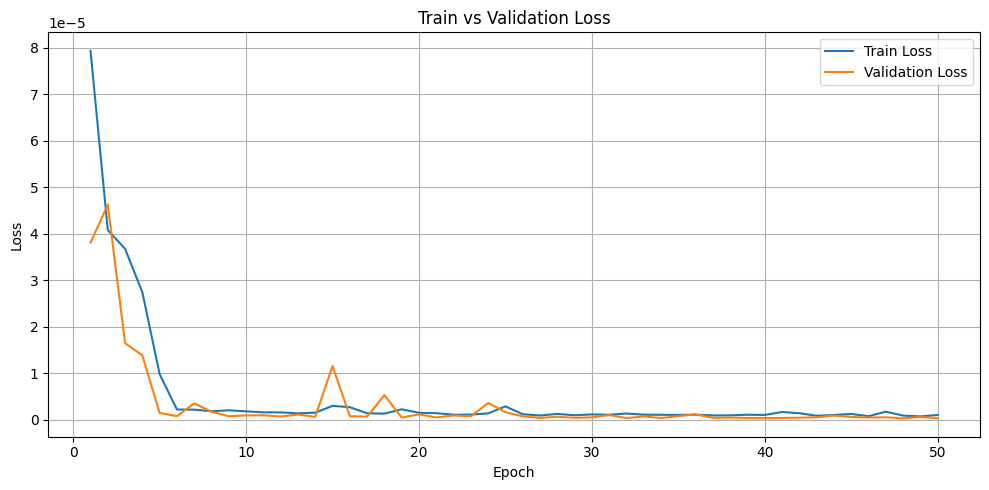


Fold 2/3
Epoch 1/50, Train Loss: 0.0002, Val Loss: 0.0026
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0026
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0000
Scaled Predictions - MSE: 0.0000, RMSE: 0.0017, R²: 0.9949
Original Predictions - MSE: 0.0965, RMSE: 0.3107, R²: 0.9949


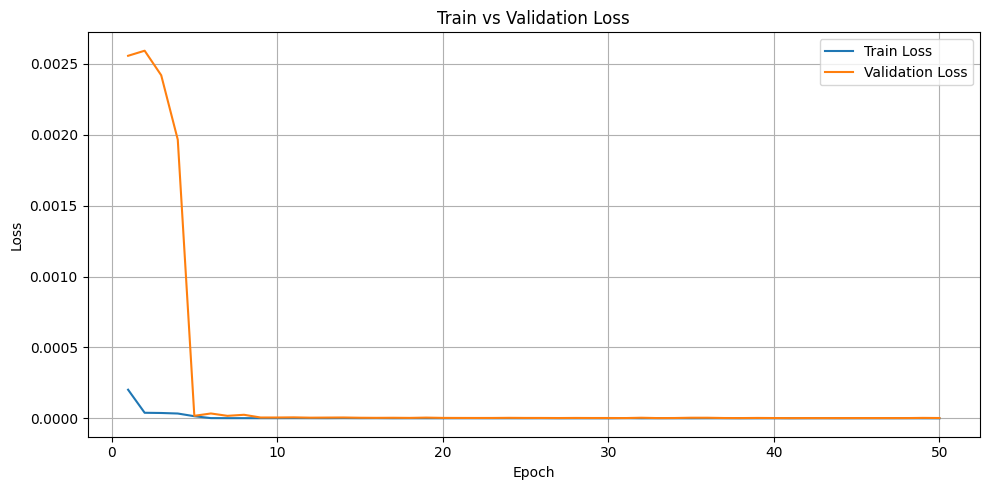


Fold 3/3
Epoch 1/50, Train Loss: 0.0006, Val Loss: 0.0116
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0106
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0041
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0021
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0020
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0025
Scaled Predictions - MSE: 0.0024, RMSE: 0.0491, R²: 0.9301
Original Predictions - MSE: 83.8236, RMSE: 9.1555, R²: 0.9301


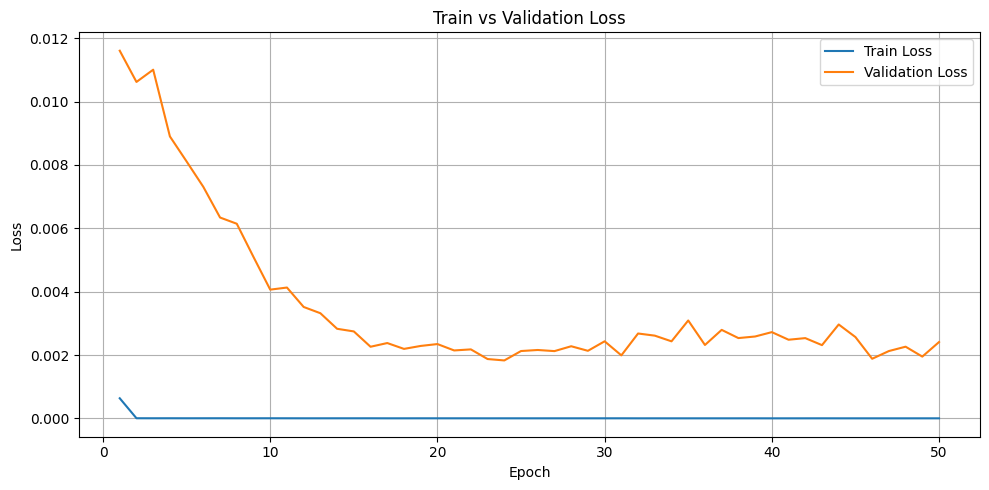

In [38]:
bilstm_fold_metrics = []
bilstm_fold_models = []

bilstm_fold_metrics, bilstm_fold_models = cross_validate_time_series(BiLSTMModel, 
                                                                 X_train_val, 
                                                                 y_train_val, 
                                                                 tscv, 
                                                                 num_epochs)

In [39]:
print(f"Rata-rata metrik per fold:")
bilstm_fold_metrics_df = pd.DataFrame(bilstm_fold_metrics)
bilstm_fold_metrics_df = bilstm_fold_metrics_df.drop(columns=['fold'])
bilstm_fold_metrics_df.mean()

Rata-rata metrik per fold:


mse         27.976770
rmse         3.188971
r2_score     0.970608
dtype: float64

In [40]:
bilstm_model = BiLSTMModel(input_size=1, hidden_size=64, num_layers=2).to(device)
optimizer_final = torch.optim.Adam(bilstm_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

bilstm_losses = []
for epoch in range(1, num_epochs + 1):
    bilstm_model.train()
    epoch_loss = 0.0
    for inputs, targets in trainval_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer_final.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer_final.step()
        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(trainval_loader.dataset)
    bilstm_losses.append(avg_loss)
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.6f}")

Epoch [1/50], Loss: 0.005449
Epoch [10/50], Loss: 0.000047
Epoch [20/50], Loss: 0.000032
Epoch [30/50], Loss: 0.000027
Epoch [40/50], Loss: 0.000035
Epoch [50/50], Loss: 0.000027


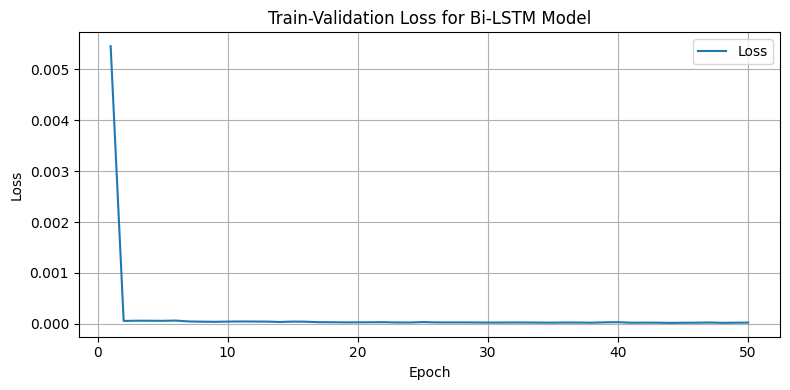

In [41]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), bilstm_losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train‐Validation Loss for Bi-LSTM Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
bilstm_model.eval()
preds_test_scaled = []
trues_test_scaled = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = bilstm_model(inputs)
        preds_test_scaled.extend(outputs.view(-1).cpu().numpy().tolist())
        trues_test_scaled.extend(targets.cpu().numpy().tolist())

preds_test_scaled = np.array(preds_test_scaled)
trues_test_scaled = np.array(trues_test_scaled)

preds_test_orig = scaler.inverse_transform(preds_test_scaled.reshape(-1, 1)).flatten()
trues_test_orig = scaler.inverse_transform(trues_test_scaled.reshape(-1, 1)).flatten()

mse_test = mean_squared_error(trues_test_orig, preds_test_orig)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(trues_test_orig, preds_test_orig)

model_metrics.append({
    'model': 'Bi-LSTM',
    'mse': mse_test,
    'rmse': rmse_test,
    'r2_score': r2_test
})

print("Evaluasi Model Bi-LSTM di Test set")
print(f"Mean Squared Error (MSE)   : {mse_test:.4f}")
print(f"Root MSE (RMSE)           : {rmse_test:.4f}")
print(f"R² Score                  : {r2_test:.4f}")

Evaluasi Model Bi-LSTM di Test set
Mean Squared Error (MSE)   : 16.5685
Root MSE (RMSE)           : 4.0704
R² Score                  : 0.9801


# Model 3 => GRU

In [43]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

gru_model = GRUModel()
summary(gru_model, input_size=(32, time_step, 1))

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [32, 1]                   --
├─GRU: 1-1                               [32, 30, 64]              37,824
├─Linear: 1-2                            [32, 1]                   65
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 36.31
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 0.15
Estimated Total Size (MB): 0.65

In [44]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
num_epochs = 50


Fold 1/3
Epoch 1/50, Train Loss: 0.0001, Val Loss: 0.0000
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0001
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0000
Scaled Predictions - MSE: 0.0000, RMSE: 0.0005, R²: 0.9873
Original Predictions - MSE: 0.0097, RMSE: 0.0987, R²: 0.9873


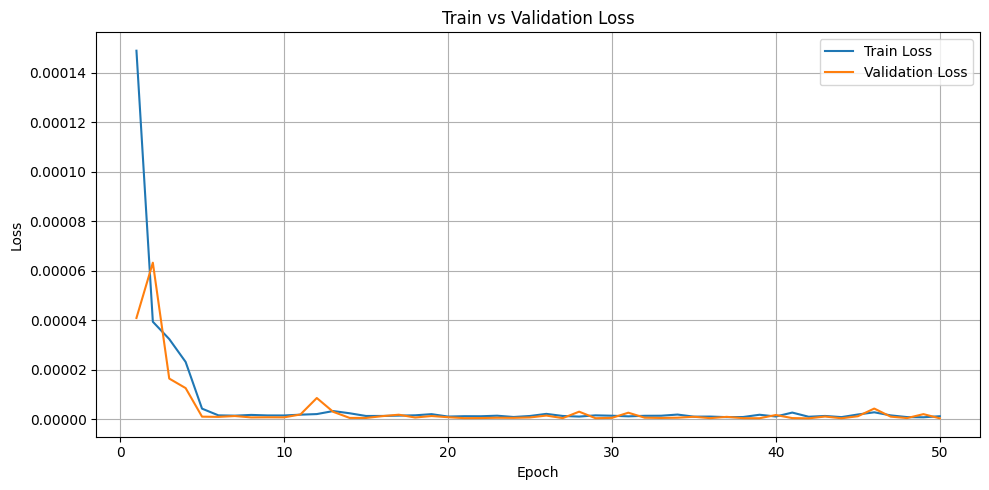


Fold 2/3
Epoch 1/50, Train Loss: 0.0001, Val Loss: 0.0029
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0020
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0000
Scaled Predictions - MSE: 0.0000, RMSE: 0.0014, R²: 0.9963
Original Predictions - MSE: 0.0705, RMSE: 0.2655, R²: 0.9963


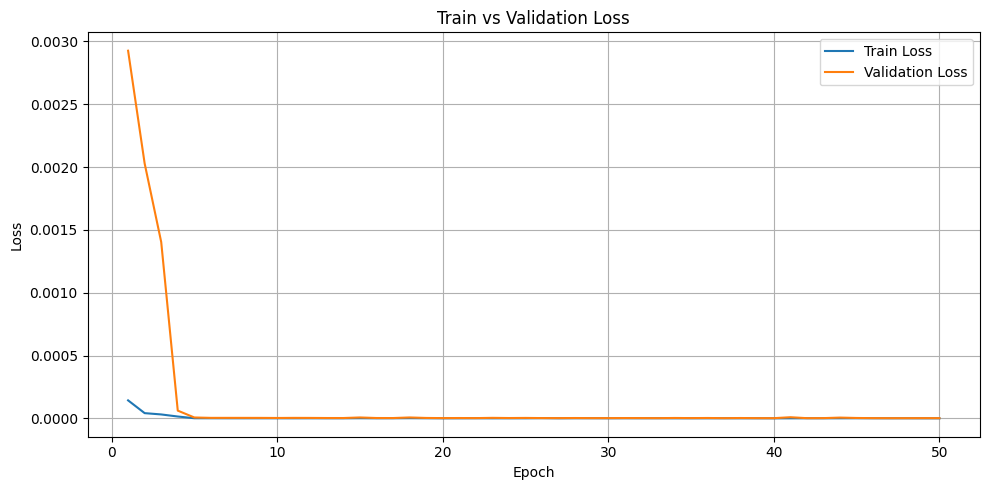


Fold 3/3
Epoch 1/50, Train Loss: 0.0005, Val Loss: 0.0014
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0007
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0004
Scaled Predictions - MSE: 0.0004, RMSE: 0.0198, R²: 0.9886
Original Predictions - MSE: 13.6422, RMSE: 3.6935, R²: 0.9886


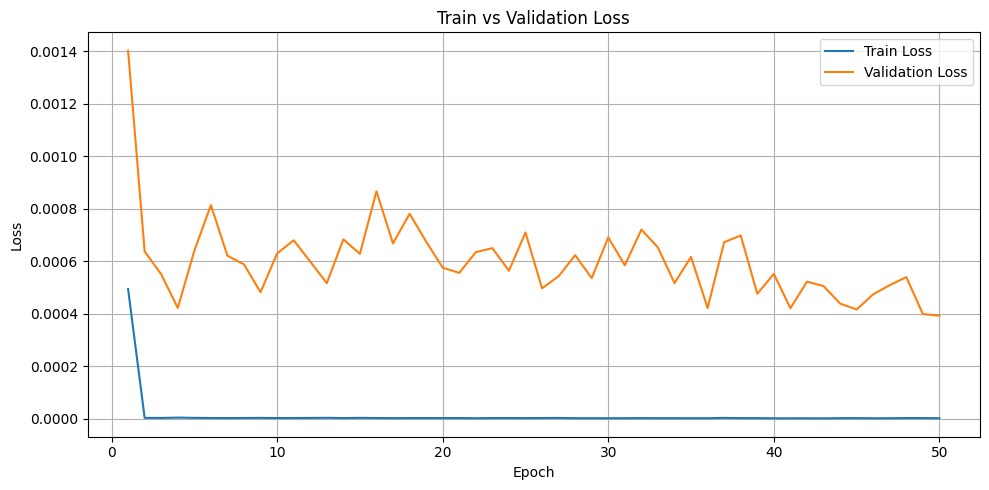

In [45]:
gru_fold_metrics = []
gru_fold_models = []

gru_fold_metrics, gru_fold_models = cross_validate_time_series(GRUModel, 
                                                                 X_train_val, 
                                                                 y_train_val, 
                                                                 tscv, 
                                                                 num_epochs)

In [46]:
print(f"Rata-rata metrik per fold:")
gru_fold_metrics_df = pd.DataFrame(gru_fold_metrics)
gru_fold_metrics_df = gru_fold_metrics_df.drop(columns=['fold'])
gru_fold_metrics_df.mean()

Rata-rata metrik per fold:


mse         4.574138
rmse        1.352582
r2_score    0.990748
dtype: float64

In [47]:
gru_model = GRUModel(input_size=1, hidden_size=64, num_layers=2).to(device)
optimizer_final = torch.optim.Adam(gru_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

gru_losses = []
for epoch in range(1, num_epochs + 1):
    gru_model.train()
    epoch_loss = 0.0
    for inputs, targets in trainval_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer_final.zero_grad()
        outputs = gru_model(inputs)
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer_final.step()
        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(trainval_loader.dataset)
    gru_losses.append(avg_loss)
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.6f}")

Epoch [1/50], Loss: 0.004360
Epoch [10/50], Loss: 0.000036
Epoch [20/50], Loss: 0.000031
Epoch [30/50], Loss: 0.000031
Epoch [40/50], Loss: 0.000023
Epoch [50/50], Loss: 0.000027


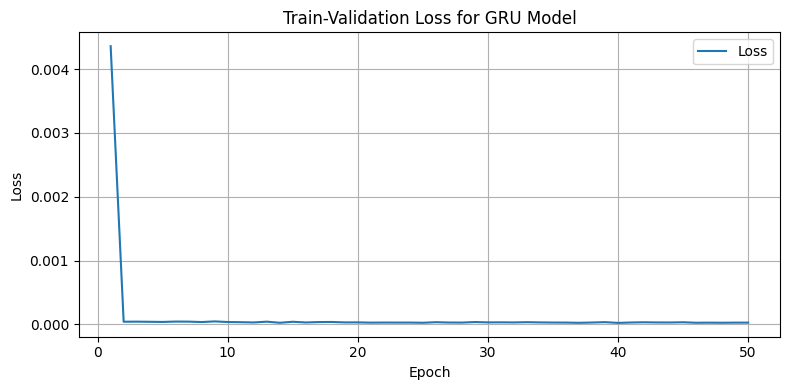

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), gru_losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train‐Validation Loss for GRU Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
gru_model.eval()
preds_test_scaled = []
trues_test_scaled = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = gru_model(inputs)
        preds_test_scaled.extend(outputs.view(-1).cpu().numpy().tolist())
        trues_test_scaled.extend(targets.cpu().numpy().tolist())

preds_test_scaled = np.array(preds_test_scaled)
trues_test_scaled = np.array(trues_test_scaled)

preds_test_orig = scaler.inverse_transform(preds_test_scaled.reshape(-1, 1)).flatten()
trues_test_orig = scaler.inverse_transform(trues_test_scaled.reshape(-1, 1)).flatten()

mse_test = mean_squared_error(trues_test_orig, preds_test_orig)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(trues_test_orig, preds_test_orig)

model_metrics.append({
    'model': 'GRU',
    'mse': mse_test,
    'rmse': rmse_test,
    'r2_score': r2_test
})

print("Evaluasi Model GRU di Test set")
print(f"Mean Squared Error (MSE)   : {mse_test:.4f}")
print(f"Root MSE (RMSE)           : {rmse_test:.4f}")
print(f"R² Score                  : {r2_test:.4f}")

Evaluasi Model GRU di Test set
Mean Squared Error (MSE)   : 11.0588
Root MSE (RMSE)           : 3.3255
R² Score                  : 0.9867


# Model 4 => Bidirectional GRU

In [50]:
class BiGRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(BiGRUModel, self).__init__()
        self.bigru = nn.GRU(
            input_size, hidden_size, num_layers,
            batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, 1)
        
    def forward(self, x):
        out, _ = self.bigru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

bigru_model = BiGRUModel()
summary(bigru_model, input_size=(32, time_step, 1))

Layer (type:depth-idx)                   Output Shape              Param #
BiGRUModel                               [32, 1]                   --
├─GRU: 1-1                               [32, 30, 128]             100,224
├─Linear: 1-2                            [32, 1]                   129
Total params: 100,353
Trainable params: 100,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 96.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.98
Params size (MB): 0.40
Estimated Total Size (MB): 1.39

In [51]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(bigru_model.parameters(), lr=0.001)
num_epochs = 50


Fold 1/3
Epoch 1/50, Train Loss: 0.0003, Val Loss: 0.0001
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0000
Scaled Predictions - MSE: 0.0000, RMSE: 0.0005, R²: 0.9875
Original Predictions - MSE: 0.0096, RMSE: 0.0982, R²: 0.9875


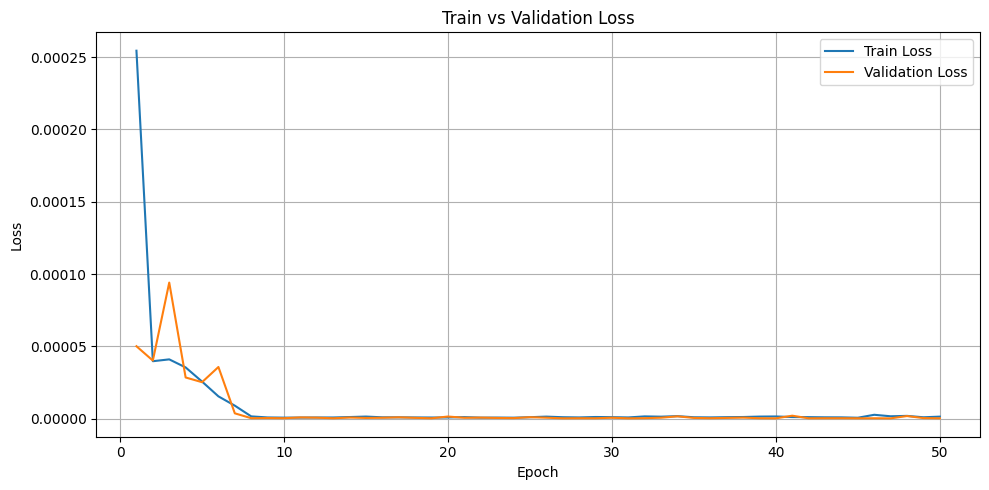


Fold 2/3
Epoch 1/50, Train Loss: 0.0004, Val Loss: 0.0026
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0023
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0000
Scaled Predictions - MSE: 0.0000, RMSE: 0.0020, R²: 0.9928
Original Predictions - MSE: 0.1367, RMSE: 0.3697, R²: 0.9928


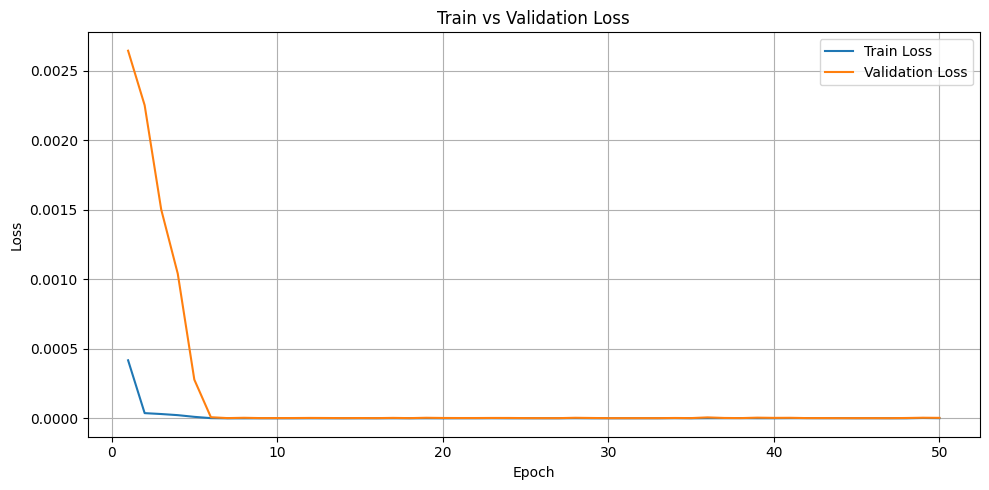


Fold 3/3
Epoch 1/50, Train Loss: 0.0005, Val Loss: 0.0010
Epoch 2/50, Train Loss: 0.0000, Val Loss: 0.0007
Epoch 11/50, Train Loss: 0.0000, Val Loss: 0.0004
Epoch 21/50, Train Loss: 0.0000, Val Loss: 0.0002
Epoch 31/50, Train Loss: 0.0000, Val Loss: 0.0002
Epoch 41/50, Train Loss: 0.0000, Val Loss: 0.0002
Scaled Predictions - MSE: 0.0002, RMSE: 0.0145, R²: 0.9939
Original Predictions - MSE: 7.2889, RMSE: 2.6998, R²: 0.9939


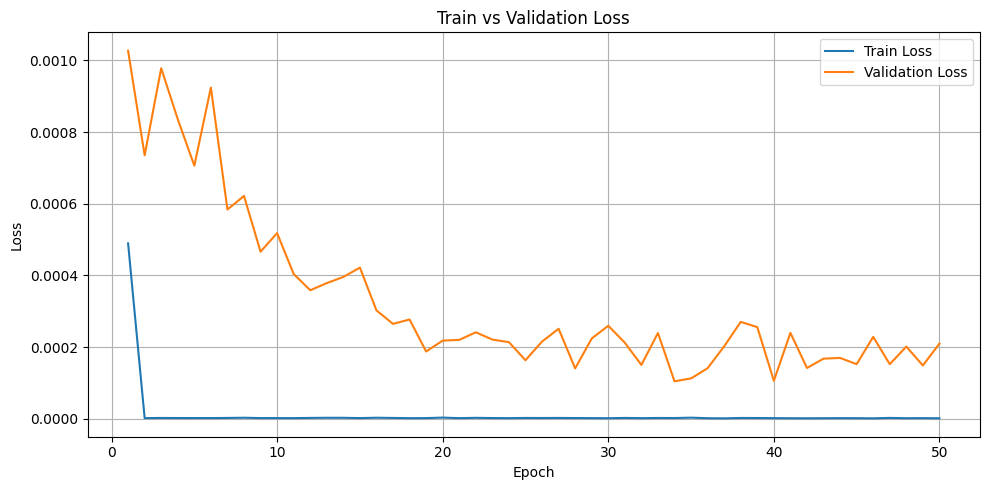

In [52]:
bigru_fold_metrics = []
bigru_fold_models = []

bigru_fold_metrics, bigru_fold_models = cross_validate_time_series(BiGRUModel, 
                                                                 X_train_val, 
                                                                 y_train_val, 
                                                                 tscv, 
                                                                 num_epochs)

In [53]:
print(f"Rata-rata metrik per fold:")
bigru_fold_metrics_df = pd.DataFrame(bigru_fold_metrics)
bigru_fold_metrics_df = bigru_fold_metrics_df.drop(columns=['fold'])
bigru_fold_metrics_df.mean()

Rata-rata metrik per fold:


mse         2.478415
rmse        1.055888
r2_score    0.991402
dtype: float64

In [54]:
bigru_model = BiGRUModel(input_size=1, hidden_size=64, num_layers=2).to(device)
optimizer_final = torch.optim.Adam(bigru_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

bigru_losses = []
for epoch in range(1, num_epochs + 1):
    bigru_model.train()
    epoch_loss = 0.0
    for inputs, targets in trainval_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer_final.zero_grad()
        outputs = bigru_model(inputs)
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer_final.step()
        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(trainval_loader.dataset)
    bigru_losses.append(avg_loss)
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.6f}")

Epoch [1/50], Loss: 0.002019
Epoch [10/50], Loss: 0.000032
Epoch [20/50], Loss: 0.000036
Epoch [30/50], Loss: 0.000027
Epoch [40/50], Loss: 0.000026
Epoch [50/50], Loss: 0.000026


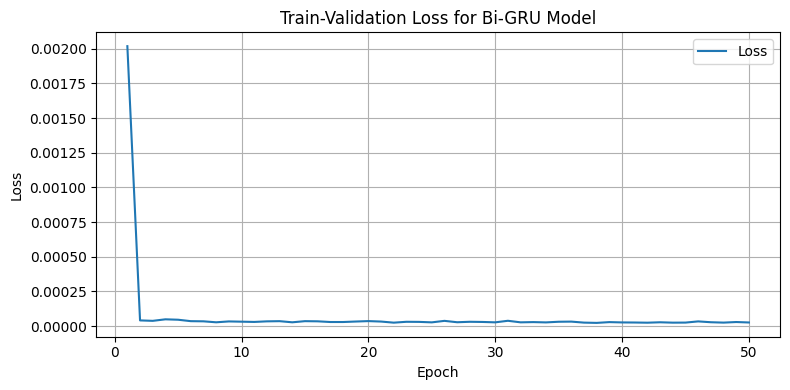

In [55]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), bigru_losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train‐Validation Loss for Bi-GRU Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
bigru_model.eval()
preds_test_scaled = []
trues_test_scaled = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = bigru_model(inputs)
        preds_test_scaled.extend(outputs.view(-1).cpu().numpy().tolist())
        trues_test_scaled.extend(targets.cpu().numpy().tolist())

preds_test_scaled = np.array(preds_test_scaled)
trues_test_scaled = np.array(trues_test_scaled)

preds_test_orig = scaler.inverse_transform(preds_test_scaled.reshape(-1, 1)).flatten()
trues_test_orig = scaler.inverse_transform(trues_test_scaled.reshape(-1, 1)).flatten()

mse_test = mean_squared_error(trues_test_orig, preds_test_orig)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(trues_test_orig, preds_test_orig)

model_metrics.append({
    'model': 'Bi-GRU',
    'mse': mse_test,
    'rmse': rmse_test,
    'r2_score': r2_test
})

print("Evaluasi Model Bi-GRU di Test set")
print(f"Mean Squared Error (MSE)   : {mse_test:.4f}")
print(f"Root MSE (RMSE)           : {rmse_test:.4f}")
print(f"R² Score                  : {r2_test:.4f}")

Evaluasi Model Bi-GRU di Test set
Mean Squared Error (MSE)   : 12.6645
Root MSE (RMSE)           : 3.5587
R² Score                  : 0.9848


# 📝 Results

In [57]:
# sort model metrics
model_metrics_df = pd.DataFrame(model_metrics)
model_metrics_df = model_metrics_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
print("Model Metrics:") 
model_metrics_df

Model Metrics:


,model,mse,rmse,r2_score
0,GRU,11.058750,3.325470,0.986713
1,Bi-GRU,12.664537,3.558727,0.984784
2,Bi-LSTM,16.568503,4.070443,0.980094
3,LSTM,18.191560,4.265157,0.978143


Berdasarkan hasil evaluasi tersebut, model **GRU** adalah model terbaik yang dapat digunakan untuk memprediksi fitur `Close` secara autoregressive. 